In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
import numpy as np

import matplotlib.pyplot as plt

In [4]:
# Load Images and Split in Train and Test Data
train_ds, validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory='flowerdataset/augmented',
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="both",
    seed = 42,
    batch_size=32,
    image_size=(299, 299),
    interpolation="nearest",
    shuffle=True)

val_batches= tf.data.experimental.cardinality(validation_ds)
test_ds= validation_ds.take(val_batches// 5)
validation_ds= validation_ds.skip(val_batches// 5)

print('Number of training batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Found 8762 files belonging to 9 classes.
Using 7010 files for training.
Using 1752 files for validation.
Number of training batches: 220
Number of validation batches: 44
Number of test batches: 11


In [5]:
### Test Xception Model without changes

# Load an image
img_path = 'Rose.jpeg'
img = image.load_img(img_path, target_size=(299, 299))
# Convert the image to a numpy array
img_array = image.img_to_array(img)
# Expand the dimensions to match the input shape expected by the model
img_array = tf.expand_dims(img_array, axis=0)
# Preprocess the image
img_array = preprocess_input(img_array)
# Load the Xception model
model = tf.keras.applications.Xception()
# Make predictions
predictions = model.predict(img_array)
# Decode and print the top-3 predicted classes
print('Predicted:', decode_predictions(predictions, top=3)[0])

1/1 [==============================] - 1s 1s/step
Predicted: [('n04525038', 'velvet', 0.11606664), ('n03534580', 'hoopskirt', 0.10689323), ('n04522168', 'vase', 0.078792915)]


In [6]:
### Load Base Model Xception
base_model = tf.keras.applications.Xception(
weights="imagenet", # Load weights pre-trained on ImageNet.
input_shape=(299, 299, 3),
include_top=False,
)

# Freeze the base_model
base_model.trainable = False
# Create new model on top
inputs = tf.keras.Input(shape=(299, 299, 3))
# Pre-trained Xception weights requires that input be scaled from (0, 255) to a range of (-1., +1.), the rescaling layer
scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x) # Regularize with dropout
outputs = tf.keras.layers.Dense(9, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 299, 299, 3)       0         Y          
                                                                            
 xception (Functional)       (None, 10, 10, 2048)      20861480  N          
                                                                            
 global_average_pooling2d (G  (None, 2048)             0         Y          
 lobalAveragePooling2D)                                                     
                                                                            
 dropout (Dropout)           (None, 2048)              0         Y          
                                                             

In [7]:
### Train new Layers
model.compile(optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=['accuracy'])
initial_epochs = 4
print("Fitting the top layer of the model")
history = model.fit(train_ds, epochs=initial_epochs, validation_data=validation_ds)

Fitting the top layer of the model
Epoch 1/4
174/220 [======================>.......] - ETA: 1:50 - loss: 1.0977 - accuracy: 0.6938

In [1]:
# Access training and validation metrics from history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation metrics
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(min(acc), min(val_acc)), 1])
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')

NameError: name 'history' is not defined

In [2]:
 # Fine Tuning the model
 base_model.trainable= True
 model.summary(show_trainable=True)

 model.compile(
 optimizer=tf.keras.optimizers.Adam(1e-5), # Low learning rate
 loss="categorical_crossentropy",
 metrics=['accuracy']
 )
 epochs = 1
 print("Fitting the end-to-end model")
 history_fine= model.fit(train_ds, epochs=epochs, validation_data=validation_ds)
 acc+= history_fine.history['accuracy']
 val_acc+= history_fine.history['val_accuracy']
 loss += history_fine.history['loss']
 val_loss+= history_fine.history['val_loss']

NameError: name 'base_model' is not defined

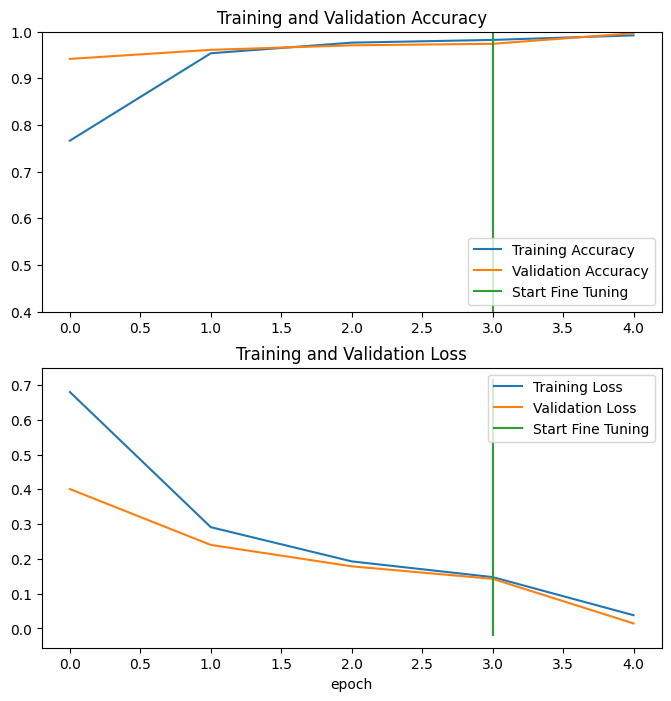

In [12]:
 # Plot the training and validation metrics of fine tuned model

 plt.figure(figsize=(8, 8))
 plt.subplot(2, 1, 1)
 plt.plot(acc, label='Training Accuracy')
 plt.plot(val_acc, label='Validation Accuracy')
 plt.ylim([0.4, 1]) # set the y-axis limits
 plt.plot([initial_epochs-1,initial_epochs-1],
 plt.ylim(), label='Start Fine Tuning')
 plt.legend(loc='lower right')
 plt.title('Training and Validation Accuracy')
 plt.subplot(2, 1, 2)
 plt.plot(loss, label='Training Loss')
 plt.plot(val_loss, label='Validation Loss')
 plt.plot([initial_epochs-1,initial_epochs-1],
 plt.ylim(), label='Start Fine Tuning')
 plt.legend(loc='upper right')
 plt.title('Training and Validation Loss')
 plt.xlabel('epoch')
 plt.show()

Predictions:
 [2 1 2 0 1 2 0 0 2 0 2 2 0 0 1 1 2 0 2 2 0 2 0 2 1]
Labels:
 [[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


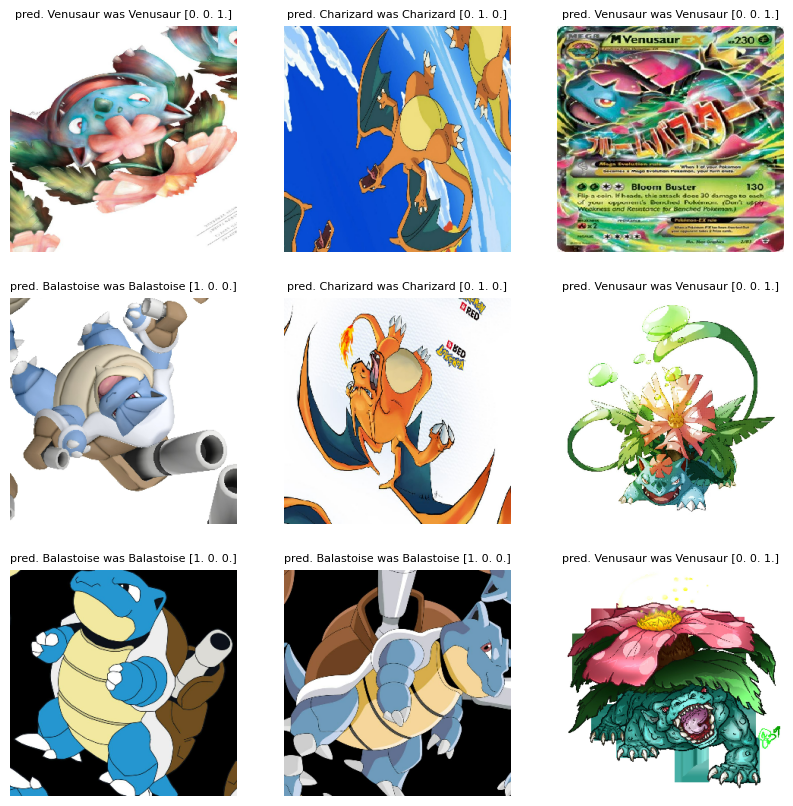

In [18]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions_in_percentage = model.predict_on_batch(image_batch)

# Class Names
class_names = ['Balastoise', 'Charizard', 'Venusaur']

# Apply a sigmoid since our model returns logits
#predictions = tf.nn.sigmoid(predictions)
predictions = np.argmax(predictions_in_percentage, axis=-1)
print('Predictions:\n', predictions)
print('Labels:\n', label_batch)
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title('pred. ' + class_names[predictions[i]] + ' was ' + class_names[np.argmax(label_batch[i])] + ' ' +
      str(np.round(predictions_in_percentage[i], 2)), fontsize=8)
  plt.axis("off")

In [19]:
model.save('pokemon_classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
